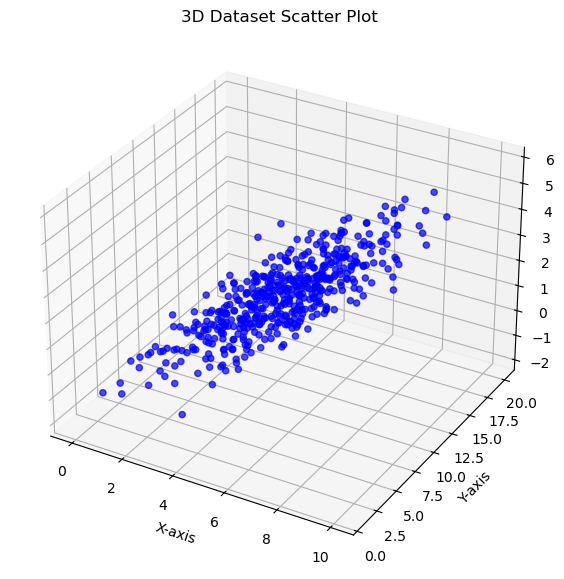

(array([ 0.41723172,  3.84095596, 10.72088263]),
 array([[ 0.63138214,  0.71890944, -0.29073323],
        [-0.04255484, -0.34222588, -0.93865357],
        [-0.77430335,  0.60502121, -0.18548223]]))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mean_vector = [5, 10, 2]
covariance_matrix = [[3, 2, 2], [2, 10, 1], [2, 1, 2]]

data = np.random.multivariate_normal(mean_vector, covariance_matrix, 500)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='blue', marker='o', alpha=0.7)
ax.set_title("3D Dataset Scatter Plot")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()

centered_data = data - np.mean(data, axis=0)

computed_covariance_matrix = np.cov(centered_data, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eigh(computed_covariance_matrix)

eigenvalues, eigenvectors


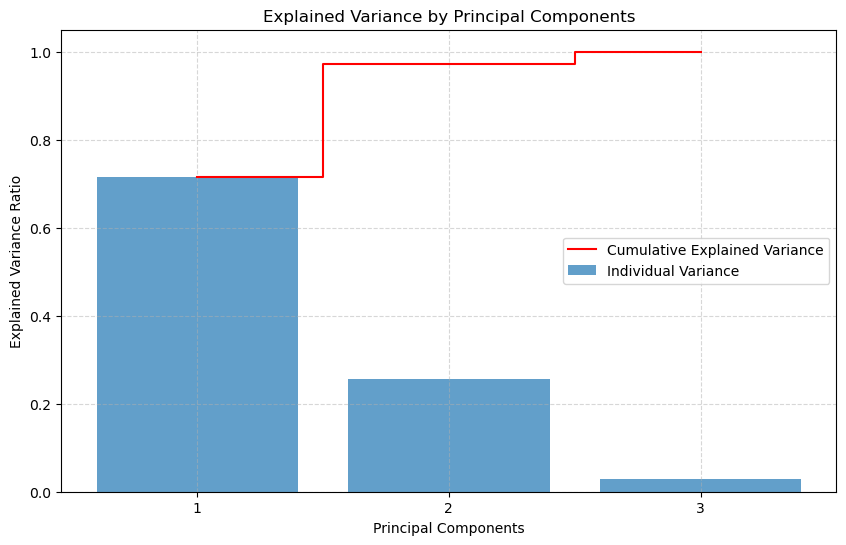

In [2]:
import matplotlib.pyplot as plt

sorted_eigenvalues = np.sort(eigenvalues)[::-1]

cumulative_variance = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)
individual_variances = sorted_eigenvalues / np.sum(sorted_eigenvalues)

plt.figure(figsize=(10, 6))

plt.bar(range(1, len(individual_variances) + 1), individual_variances, alpha=0.7, label="Individual Variance")

plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red', label="Cumulative Explained Variance")

plt.xlabel("Princal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by Principal Components")
plt.xticks(range(1, len(individual_variances) + 1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


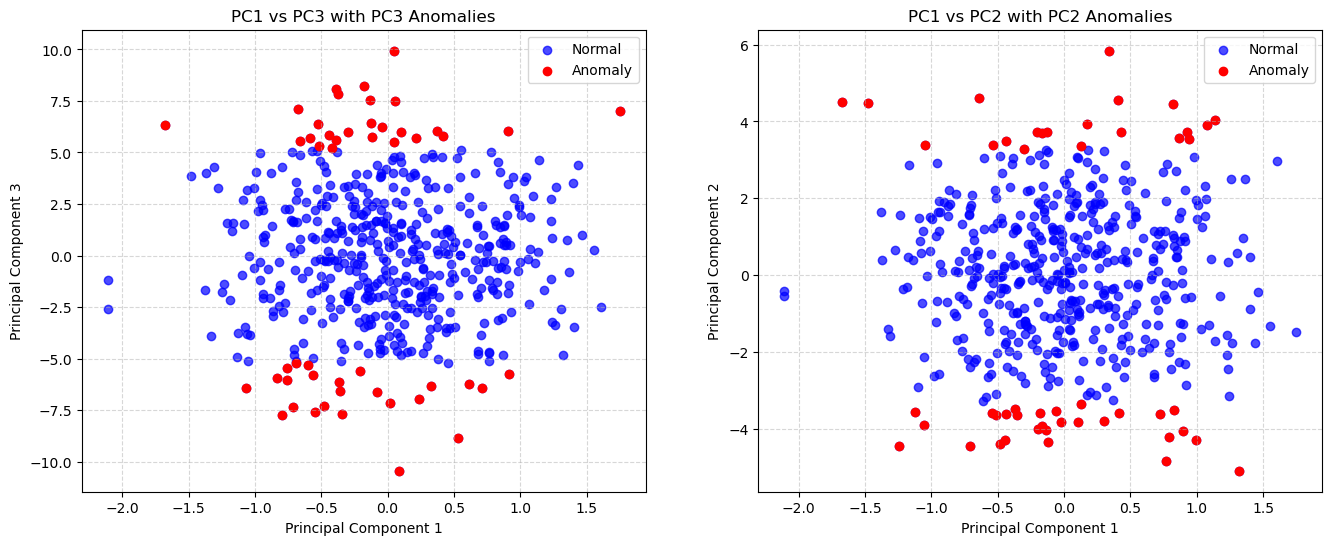

(5.207849227138275, 3.2822155763053913)

In [3]:
projected_data = centered_data @ eigenvectors

def identify_anomalies(component_values, contamination_rate=0.1):
    threshold = np.quantile(np.abs(component_values), 1 - contamination_rate)
    anomalies = np.abs(component_values) > threshold
    return anomalies, threshold

pc3_anomalies, pc3_threshold = identify_anomalies(projected_data[:, 2])

pc2_anomalies, pc2_threshold = identify_anomalies(projected_data[:, 1])

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(projected_data[:, 0], projected_data[:, 2], c='blue', label='Normal', alpha=0.7)
ax[0].scatter(projected_data[pc3_anomalies, 0], projected_data[pc3_anomalies, 2], c='red', label='Anomaly')
ax[0].set_title("PC1 vs PC3 with PC3 Anomalies")
ax[0].set_xlabel("Principal Component 1")
ax[0].set_ylabel("Principal Component 3")
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.5)

ax[1].scatter(projected_data[:, 0], projected_data[:, 1], c='blue', label='Normal', alpha=0.7)
ax[1].scatter(projected_data[pc2_anomalies, 0], projected_data[pc2_anomalies, 1], c='red', label='Anomaly')
ax[1].set_title("PC1 vs PC2 with PC2 Anomalies")
ax[1].set_xlabel("Principal Component 1")
ax[1].set_ylabel("Principal Component 2")
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.5)

plt.show()

pc3_threshold, pc2_threshold


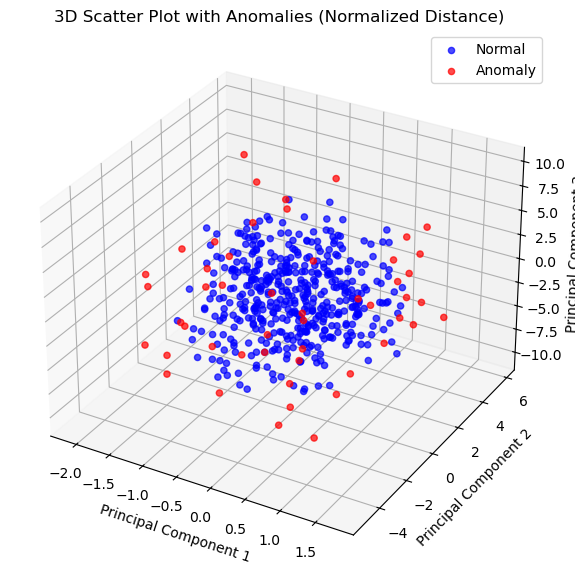

2.4612039172576754

In [4]:

std_devs = np.std(projected_data, axis=0)
normalized_data = projected_data / std_devs


distances = np.linalg.norm(normalized_data, axis=1)


contamination_rate = 0.1
distance_threshold = np.quantile(distances, 1 - contamination_rate)

distance_anomalies = distances > distance_threshold


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(projected_data[~distance_anomalies, 0], 
           projected_data[~distance_anomalies, 1], 
           projected_data[~distance_anomalies, 2], 
           c='blue', label='Normal', alpha=0.7)


ax.scatter(projected_data[distance_anomalies, 0], 
           projected_data[distance_anomalies, 1], 
           projected_data[distance_anomalies, 2], 
           c='red', label='Anomaly', alpha=0.7)


ax.set_title("3D Scatter Plot with Anomalies (Normalized Distance)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.legend()
plt.show()

distance_threshold


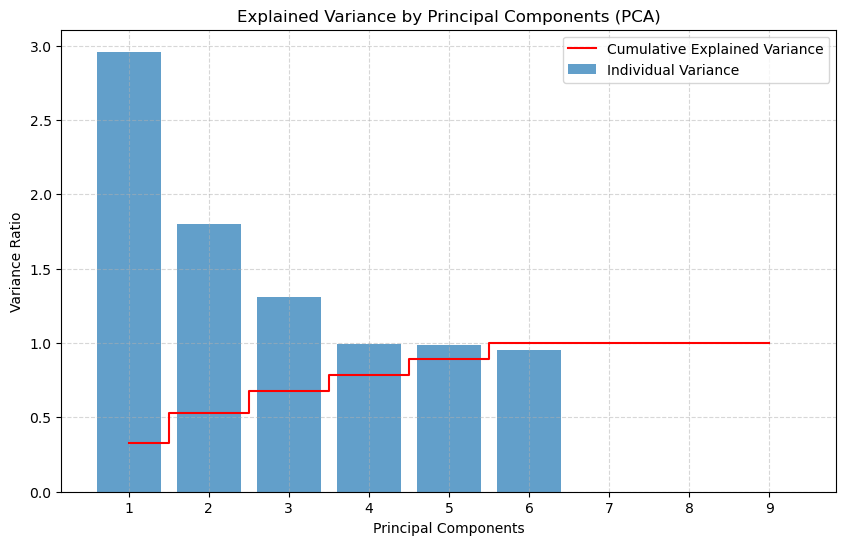

In [1]:
#2
from pyod.models.pca import PCA
from pyod.utils.utility import standardizer
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
data=loadmat("shuttle.mat")
X_train, X_test, y_train, y_test = train_test_split(data["X"], data["y"], test_size=0.6,random_state=42)
X_train_norm, X_test_norm = standardizer(X_train, X_test)

c_rate=sum([1 for y in y_train if y==1])/len(y_train)
pca=PCA(contamination=c_rate)
pca.fit(X_train_norm)

explained_variances = pca.explained_variance_
cumulative_variances = np.cumsum(explained_variances)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, alpha=0.7, label="Individual Variance")

plt.step(range(1, len(cumulative_variances) + 1), cumulative_variances / cumulative_variances[-1], 
         where='mid', color='red', label="Cumulative Explained Variance")
plt.xlabel("Principal Components")
plt.ylabel("Variance Ratio")
plt.title("Explained Variance by Principal Components (PCA)")
plt.xticks(range(1, len(explained_variances) + 1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
from sklearn.metrics import balanced_accuracy_score
from pyod.models.kpca import KPCA
pca_train_scores = pca.decision_function(X_train_norm)
pca_test_scores = pca.decision_function(X_test_norm)

pred_train_pca=pca.predict(X_train_norm)
pred_test_pca=pca.predict(X_test_norm)

pca_train_bal_acc = balanced_accuracy_score(y_train, pred_train_pca)
pca_test_bal_acc = balanced_accuracy_score(y_test, pred_test_pca)

print(f"Pca train: {pca_train_bal_acc}, Pca test: {pca_test_bal_acc}")

kpca=KPCA(contamination=c_rate)
kpca.fit(X_train_norm)

kpca_train_scores = kpca.decision_function(X_train_norm)
kpca_test_scores = kpca.decision_function(X_test_norm)

pred_train_kpca=kpca.predict(X_train_norm)
pred_test_kpca=kpca.predict(X_test_norm)

kpca_train_bal_acc = balanced_accuracy_score(y_train, pred_train_kpca)
kpca_test_bal_acc = balanced_accuracy_score(y_test, pred_test_kpca)

print(f"Kpca train: {kpca_train_bal_acc}, Kpca test: {kpca_test_bal_acc}")

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0227 - val_loss: 0.0217
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0214 - val_loss: 0.0206
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203 - val_loss: 0.0195
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0192 - val_loss: 0.0185
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0182 - val_loss: 0.0175
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0173 - val_loss: 0.0166
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0164 - val_loss: 0.0158
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0156 - val_loss: 0.0151
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - val_loss: 0.0143
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - val_loss: 0.0137
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

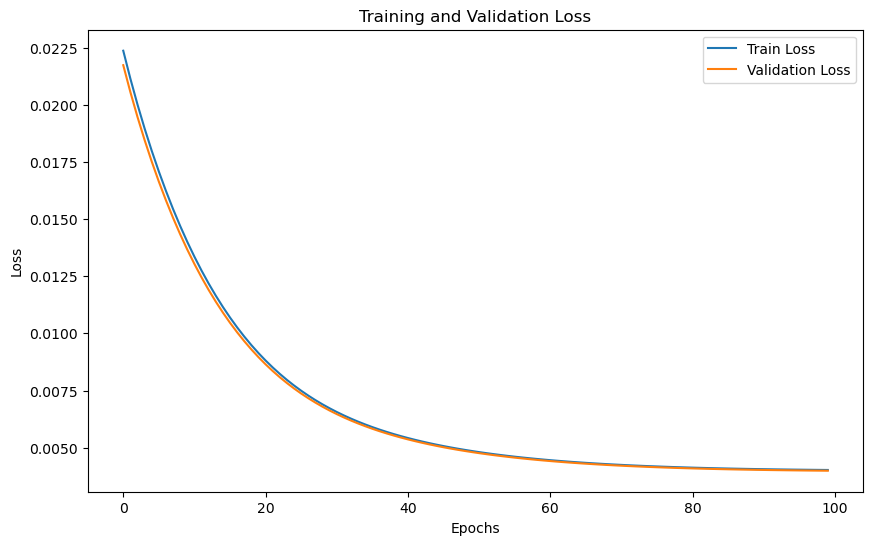

Balanced Accuracy on Training Set: 0.9708


In [6]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential


X_train, X_test, y_train, y_test = train_test_split(data["X"], data["y"], test_size=0.5,random_state=42)
c_rate=sum([1 for y in y_train if y==1])/len(y_train)
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = Sequential([
            layers.Dense(8, activation='relu'),
            layers.Dense(5, activation='relu'),
            layers.Dense(3, activation='relu')
        ])

        self.decoder = Sequential([
            layers.Dense(5, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(9, activation='sigmoid')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

history=autoencoder.fit(X_train_norm, X_train_norm, epochs=100, batch_size=1024, validation_data=(X_test_norm, X_test_norm))

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

train_reconstruction = autoencoder(X_train_norm).numpy()
train_errors = np.mean(np.square(X_train_norm - train_reconstruction), axis=1)
threshold = np.quantile(train_errors, 1 - c_rate)

train_predictions = (train_errors > threshold).astype(int)

train_balanced_accuracy = balanced_accuracy_score(y_train, train_predictions)

print(f"Balanced Accuracy on Training Set: {train_balanced_accuracy:.4f}")




In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

noise_factor = 0.35
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=tf.shape(x_train), mean=0.0, stddev=1.0)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=tf.shape(x_test), mean=0.0, stddev=1.0)

# 4. Clip the pixel values to keep them in the range [0, 1]
x_train_noisy = tf.clip_by_value(x_train_noisy, 0.0, 1.0)
x_test_noisy = tf.clip_by_value(x_test_noisy, 0.0, 1.0)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step


In [9]:
from tensorflow.keras import layers, models
class ConvAutoencoder(models.Model):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.encoder = models.Sequential([
            layers.Conv2D(8, (3, 3), activation='relu', strides=2, padding='same', input_shape=(28, 28, 1)),
            layers.Conv2D(4, (3, 3), activation='relu', strides=2, padding='same')
        ])
        
        self.decoder = models.Sequential([
            layers.Conv2DTranspose(4, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(8, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = ConvAutoencoder()
autoencoder.compile(optimizer='adam', loss='mse')


autoencoder.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

train_reconstructions = autoencoder(x_train)
train_mse = tf.reduce_mean(tf.square(x_train - train_reconstructions), axis=(1, 2, 3))

mean_error = tf.reduce_mean(train_mse).numpy()
std_error = tf.reduce_std(train_mse).numpy()
threshold = mean_error + std_error

test_reconstructions = autoencoder(x_test)
test_mse = tf.reduce_mean(tf.square(x_test - test_reconstructions), axis=(1, 2, 3))

test_noisy_reconstructions = autoencoder(x_test_noisy)
test_noisy_mse = tf.reduce_mean(tf.square(x_test_noisy - test_noisy_reconstructions), axis=(1, 2, 3))

test_predictions = (test_mse > threshold).numpy()
test_noisy_predictions = (test_noisy_mse > threshold).numpy()

true_labels = np.zeros_like(test_predictions)
true_labels_noisy = np.ones_like(test_noisy_predictions)

original_test_accuracy = accuracy_score(true_labels, test_predictions)
noisy_test_accuracy = accuracy_score(true_labels_noisy, test_noisy_predictions)

print(f'Accuracy on original test images: {original_test_accuracy:.4f}')
print(f'Accuracy on noisy test images: {noisy_test_accuracy:.4f}')


Epoch 1/10


C:\Users\rares\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0783 - val_loss: 0.0073
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0026 - val_loss: 0.0024


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [60000,28,28] vs. [60000,28,28,1] [Op:Sub] name: 